In [1]:
%pip install pennylane
%pip install qiskit

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
import pennylane as qml
# import qiskit
# from qlstm_pennylane import QLSTM

Here we define the possible tags: determinant, noun, verb.

In [4]:
tag_to_ix = {"DET": 0, "NN": 1, "V": 2, "PRON":3,  "ADV":4, "ADJ":5, "IN":6}  # Assign each tag with a unique index
ix_to_tag = {i:k for k,i in tag_to_ix.items()}

The function below tokenizes the sentence and matches the label to each word.

In [5]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

Now we can prepare the input dataset.

In [6]:
vocab = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"]),
    ("She sings beautifully".split(), ["PRON", "V", "ADV"]),
    ("The big red apple fell from the tree".split(), ["DET", "ADJ", "ADJ", "NN", "V", "IN", "DET", "NN"]),
    ("They ran quickly to the park".split(), ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    ("He read the book slowly".split(), ["PRON", "V", "DET", "NN", "ADV"]),
    ("The dogs barked loudly".split(), ["DET", "NN", "V", "ADV"]),
    ("The tall building stood alone in the city".split(), ["DET", "ADJ", "NN", "V", "ADV", "IN", "DET", "NN"]),
    ("She ate a delicious cake for dessert".split(), ["PRON", "V", "DET", "ADJ", "NN", "IN", "NN"]),
    ("The children played happily in the park".split(), ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    ("The boy climbed the tall tree".split(), ["DET", "NN", "V", "DET", "ADJ", "NN"]),
    ("She carefully placed the vase on the table".split(), ["PRON", "ADV", "V", "DET", "NN", "IN", "DET", "NN"]),
    ("The wind howled loudly during the storm".split(), ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    ("A group of students studied together".split(), ["DET", "NN", "IN", "NN", "V", "ADV"]),
    ("The teacher explained the lesson patiently".split(), ["DET", "NN", "V", "DET", "NN", "ADV"]),
    ("He loves playing football with his friends".split(), ["PRON", "V", "V", "NN", "IN", "DET", "NN"]),
    ("They walked cautiously across the bridge".split(), ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    ("The small kitten meowed loudly at night".split(), ["DET", "ADJ", "NN", "V", "ADV", "IN", "NN"]),
    ("She opened the window to let in fresh air".split(), ["PRON", "V", "DET", "NN", "IN", "V", "IN", "ADJ", "NN"]),
    ("The man drove carefully in the rain".split(), ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    ("The old woman told stories about her youth".split(), ["DET", "ADJ", "NN", "V", "NN", "IN", "DET", "NN"]),
    ("The scientist conducted an experiment in the lab".split(), ["DET", "NN", "V", "DET", "NN", "IN", "DET", "NN"]),
    ("They argued heatedly over the results".split(), ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    ("The children built a sandcastle on the beach".split(), ["DET", "NN", "V", "DET", "NN", "IN", "DET", "NN"]),
    ("A colorful butterfly landed gently on the flower".split(), ["DET", "ADJ", "NN", "V", "ADV", "IN", "DET", "NN"]),
    ("The sun rises early in the summer".split(), ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    ("He painted the house beautifully with vibrant colors".split(), ["PRON", "V", "DET", "NN", "ADV", "IN", "ADJ", "NN"]),
    ("The artist created a masterpiece using oil paints".split(), ["DET", "NN", "V", "DET", "NN", "V", "NN"]),
    ("The rain fell gently on the grass".split(), ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    ("She walked briskly to the market".split(), ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    ("The chef cooked an exquisite meal for the guests".split(), ["DET", "NN", "V", "DET", "ADJ", "NN", "IN", "DET", "NN"]),
    ("The boy threw the ball high into the air".split(), ["DET", "NN", "V", "DET", "NN", "ADV", "IN", "DET", "NN"]),
    ("The river flows peacefully through the valley".split(), ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    ("The crowd cheered loudly for the performers".split(), ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    ("She tied her hair into a neat bun".split(), ["PRON", "V", "DET", "NN", "IN", "DET", "ADJ", "NN"]),
    ("The horse galloped swiftly across the meadow".split(), ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    ("The new student answered confidently in class".split(), ["DET", "ADJ", "NN", "V", "ADV", "IN", "NN"]),
    ("He plays the piano beautifully during recitals".split(), ["PRON", "V", "DET", "NN", "ADV", "IN", "NN"]),
    ("The little boy ran excitedly to the playground".split(), ["DET", "ADJ", "NN", "V", "ADV", "IN", "DET", "NN"]),
    ("She sketched a portrait of her mother".split(), ["PRON", "V", "DET", "NN", "IN", "DET", "NN"]),
    ("The clock ticked loudly in the silent room".split(), ["DET", "NN", "V", "ADV", "IN", "DET", "ADJ", "NN"]),
    ("He sang softly to calm the crying baby".split(), ["PRON", "V", "ADV", "IN", "V", "DET", "ADJ", "NN"]),
    ("The forest echoed with the sound of birds chirping".split(), ["DET", "NN", "V", "IN", "DET", "NN", "IN", "NN", "V"]),
    ("They enjoyed the movie despite the loud noise".split(), ["PRON", "V", "DET", "NN", "IN", "DET", "ADJ", "NN"]),
    ("The young girl spun gracefully on the ice".split(), ["DET", "ADJ", "NN", "V", "ADV", "IN", "DET", "NN"]),
    ("The mountain was covered in a thick layer of snow".split(), ["DET", "NN", "V", "V", "IN", "DET", "ADJ", "NN", "IN", "NN"]),
    ("He eagerly waited for the exciting news".split(), ["PRON", "ADV", "V", "IN", "DET", "ADJ", "NN"]),
    ("The flowers were arranged beautifully in the vase".split(), ["DET", "NN", "V", "V", "ADV", "IN", "DET", "NN"]),
    ("The dancers moved rhythmically to the beat of the music".split(), ["DET", "NN", "V", "ADV", "IN", "DET", "NN", "IN", "DET", "NN"]),
    ("She nervously answered the difficult question".split(), ["PRON", "ADV", "V", "DET", "ADJ", "NN"]),
    ("The team celebrated their victory joyfully".split(), ["DET", "NN", "V", "DET", "NN", "ADV"]),
    ("She discovered a hidden cave during the hike".split(), ["PRON", "V", "DET", "ADJ", "NN", "IN", "DET", "NN"]),
    ("The painter captured the sunset beautifully on canvas".split(), ["DET", "NN", "V", "DET", "NN", "ADV", "IN", "NN"]),
    ("He adjusted the sails quickly to catch the wind".split(), ["PRON", "V", "DET", "NN", "ADV", "IN", "V", "DET", "NN"]),
    ("The baby crawled slowly across the room".split(), ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    ("The farmer harvested the crops at dawn".split(), ["DET", "NN", "V", "DET", "NN", "IN", "NN"]),
    ("She wore a scarf to protect herself from the cold".split(), ["PRON", "V", "DET", "NN", "IN", "V", "PRON", "IN", "DET", "NN"]),
    ("The orchestra played a symphony magnificently".split(), ["DET", "NN", "V", "DET", "NN", "ADV"]),
    ("They explored the ancient ruins with great curiosity".split(), ["PRON", "V", "DET", "ADJ", "NN", "IN", "ADJ", "NN"]),
    ("The artist painted vivid murals on the city walls".split(), ["DET", "NN", "V", "ADJ", "NN", "IN", "DET", "NN", "NN"]),
    ("The birds flew high in the clear blue sky".split(), ["DET", "NN", "V", "ADV", "IN", "DET", "ADJ", "ADJ", "NN"]),
    ("He played chess intently with his grandfather".split(), ["PRON", "V", "NN", "ADV", "IN", "DET", "NN"]),
    ("The hikers rested briefly at the summit".split(), ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    ("The musician composed a beautiful melody at night".split(), ["DET", "NN", "V", "DET", "ADJ", "NN", "IN", "NN"]),
    ("She explained the instructions clearly to the group".split(), ["PRON", "V", "DET", "NN", "ADV", "IN", "DET", "NN"]),
    ("The children laughed loudly while playing in the yard".split(), ["DET", "NN", "V", "ADV", "IN", "V", "IN", "DET", "NN"]),
    ("He admired the starry sky through his telescope".split(), ["PRON", "V", "DET", "ADJ", "NN", "IN", "DET", "NN"]),
    ("The chef prepared a feast for the entire family".split(), ["DET", "NN", "V", "DET", "NN", "IN", "DET", "ADJ", "NN"]),
    ("The mechanic fixed the engine carefully in the garage".split(), ["DET", "NN", "V", "DET", "NN", "ADV", "IN", "DET", "NN"]),
    ("The scientist analyzed the data thoroughly before publishing".split(), ["DET", "NN", "V", "DET", "NN", "ADV", "IN", "V"]),
    ("The dog fetched the ball and brought it back".split(), ["DET", "NN", "V", "DET", "NN", "CONJ", "V", "PRON", "ADV"]),
    ("She climbed the ladder cautiously to reach the top shelf".split(), ["PRON", "V", "DET", "NN", "ADV", "IN", "V", "DET", "ADJ", "NN"]),
    ("The students practiced their presentation with enthusiasm".split(), ["DET", "NN", "V", "DET", "NN", "IN", "NN"]),
    ("He observed the stars quietly through the telescope".split(), ["PRON", "V", "DET", "NN", "ADV", "IN", "DET", "NN"]),
    ("The little girl tied her shoes before running outside".split(), ["DET", "ADJ", "NN", "V", "DET", "NN", "IN", "V", "ADV"]),
    ("The team worked hard to complete the challenging task".split(), ["DET", "NN", "V", "ADJ", "IN", "V", "DET", "ADJ", "NN"]),
    ("She polished the wooden table until it gleamed".split(), ["PRON", "V", "DET", "ADJ", "NN", "IN", "PRON", "V"]),
    ("The students debated the topic passionately in class".split(), ["DET", "NN", "V", "DET", "NN", "ADV", "IN", "NN"]),
    ("The cat chased the mouse into the dark corner".split(), ["DET", "NN", "V", "DET", "NN", "IN", "DET", "ADJ", "NN"]),
    ("He poured a cup of tea and served it to his guest".split(), ["PRON", "V", "DET", "NN", "IN", "NN", "CONJ", "V", "PRON", "IN", "DET", "NN"]),
    ("The storm raged fiercely through the night".split(), ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    ("She meticulously arranged the flowers in the vase".split(), ["PRON", "ADV", "V", "DET", "NN", "IN", "DET", "NN"]),
    ("The baby smiled brightly at her parents".split(), ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    ("They wandered aimlessly through the dense forest".split(), ["PRON", "V", "ADV", "IN", "DET", "ADJ", "NN"]),
    ("The children eagerly opened their gifts on Christmas morning".split(), ["DET", "NN", "ADV", "V", "DET", "NN", "IN", "NN", "NN"]),
    ("The librarian organized the books alphabetically on the shelves".split(), ["DET", "NN", "V", "DET", "NN", "ADV", "IN", "DET", "NN"]),
    ("He gently placed the baby in the crib and kissed her forehead".split(), ["PRON", "ADV", "V", "DET", "NN", "IN", "DET", "NN", "CONJ", "V", "DET", "NN"]),
    ("The athlete trained vigorously for the upcoming competition".split(), ["DET", "NN", "V", "ADV", "IN", "DET", "ADJ", "NN"]),
    (["The", "cats", "slept", "on", "the", "mat."], ["DET", "NN", "V", "IN", "DET", "NN"]),
    (["She", "dances", "gracefully", "on", "stage."], ["PRON", "V", "ADV", "IN", "NN"]),
    (["The", "flowers", "bloomed", "beautifully", "in", "the", "garden."], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["He", "walked", "slowly", "down", "the", "street."], ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    (["The", "children", "played", "happily", "at", "the", "park."], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["They", "ran", "quickly", "to", "catch", "the", "bus."], ["PRON", "V", "ADV", "IN", "V", "DET", "NN"]),
    (["The", "big", "yellow", "sun", "set", "over", "the", "ocean."], ["DET", "ADJ", "ADJ", "NN", "V", "IN", "DET", "NN"]),
    (["She", "wore", "a", "pretty", "dress", "to", "the", "party."], ["PRON", "V", "DET", "ADJ", "NN", "IN", "DET", "NN"]),
    (["The", "old", "men", "sat", "alone", "on", "the", "bench."], ["DET", "ADJ", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["The", "cat", "jumped", "over", "the", "fence"], ["DET", "NN", "V", "IN", "DET", "NN"]),
    (["A", "bird", "sang", "beautifully", "in", "the", "morning"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["She", "ran", "quickly", "to", "catch", "the", "bus"], ["PRON", "V", "ADV", "IN", "V", "DET", "NN"]),
    (["The", "students", "studied", "hard", "for", "the", "exam"], ["DET", "NN", "V", "ADJ", "IN", "DET", "NN"]),
    (["He", "ate", "his", "dinner", "quietly"], ["PRON", "V", "DET", "NN", "ADV"]),
    (["The", "sun", "shone", "brightly", "on", "the", "beach"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["They", "played", "happily", "in", "the", "park"], ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    (["The", "flowers", "bloomed", "vividly", "in", "the", "garden"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["She", "slept", "peacefully", "throughout", "the", "night"], ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    (["The", "children", "laughed", "joyfully", "at", "the", "joke"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["He", "spoke", "softly", "to", "his", "mother"], ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    (["The", "baby", "cried", "loudly", "in", "the", "room"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["They", "danced", "gracefully", "on", "the", "stage"], ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    (["The", "horses", "galloped", "swiftly", "across", "the", "field"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["She", "read", "carefully", "the", "instructions"], ["PRON", "V", "ADV", "DET", "NN"]),
    (["The", "dog", "barked", "loudly", "at", "the", "stranger"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["They", "swam", "gracefully", "in", "the", "ocean"], ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    (["The", "paintings", "displayed", "beautifully", "in", "the", "gallery"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["He", "wrote", "passionately", "about", "his", "experiences"], ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    (["The", "sun", "set", "slowly", "behind", "the", "mountains"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["She", "spoke", "confidently", "in", "front", "of", "the", "audience"], ["PRON", "V", "ADV", "IN", "NN", "IN", "DET", "NN"]),
    (["The", "children", "played", "happily", "in", "the", "park"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["He", "smiled", "warmly", "at", "his", "friends"], ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    (["The", "car", "drove", "swiftly", "along", "the", "highway"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["She", "answered", "quickly", "to", "his", "question"], ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    (["The", "students", "listened", "attentively", "to", "the", "lecture"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["They", "climbed", "bravely", "to", "the", "mountain", "peak"], ["PRON", "V", "ADV", "IN", "DET", "NN", "NN"]),
    (["The", "rain", "fell", "heavily", "on", "the", "roof"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["She", "ran", "frantically", "to", "catch", "the", "bus"], ["PRON", "V", "ADV", "IN", "V", "DET", "NN"]),
    (["The", "flowers", "bloomed", "colorfully", "in", "the", "garden"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["He", "ate", "hungrily", "after", "a", "long", "day"], ["PRON", "V", "ADV", "IN", "DET", "ADJ", "NN"]),
    (["The", "cat", "purred", "contentedly", "on", "the", "windowsill"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["They", "played", "enthusiastically", "in", "the", "playground"], ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    ("We heard the birds chirping loudly in the morning".split(), ["PRON", "V", "DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
]

# Create word_to_ix dictionary
word_to_ix = {}
tag_to_ix = {}

# First pass: collect all unique words and tags
for sent, tags in vocab:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)

# Add unknown tokens
word_to_ix["<UNK>"] = len(word_to_ix)
tag_to_ix["<UNK>"] = len(tag_to_ix)

# Create reverse mapping for tags (useful for evaluation)
ix_to_tag = {v: k for k, v in tag_to_ix.items()}

# Print vocabulary statistics
print(f"Vocabulary size: {len(word_to_ix)}")
print(f"Number of tags: {len(tag_to_ix)}")

def prepare_sequence(seq, to_ix):
    # Add handling for unknown words/tags
    idxs = [to_ix.get(w, to_ix["<UNK>"]) for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

# Model parameters
embedding_dim = 8
hidden_dim = 6
vocab_size = len(word_to_ix)
tagset_size = len(tag_to_ix)
n_epochs = 100

# Calculate split indices
total_samples = len(vocab)
train_size = int(0.8 * total_samples)  # 80% for training
test_size = total_samples - train_size  # 20% for testing

# Shuffle and split the data
import random
random.seed(42)
shuffled_vocab = vocab.copy()
random.shuffle(shuffled_vocab)

training_data = shuffled_vocab[:train_size]
testing_data = shuffled_vocab[train_size:]

# Print statistics
print(f"\nDataset statistics:")
print(f"Total samples: {total_samples}")
print(f"Training samples: {len(training_data)} ({len(training_data)/total_samples*100:.1f}%)")
print(f"Testing samples: {len(testing_data)} ({len(testing_data)/total_samples*100:.1f}%)")

Vocabulary size: 421
Number of tags: 9

Dataset statistics:
Total samples: 131
Training samples: 104 (79.4%)
Testing samples: 27 (20.6%)


Shuffling the data before splitting to ensure random distribution

In [7]:
import random

# Set random seed for reproducibility
random.seed(42)

# Create shuffled copy of vocab
shuffled_vocab = vocab.copy()
random.shuffle(shuffled_vocab)

# Split the shuffled data
training_data = shuffled_vocab[:train_size]
testing_data = shuffled_vocab[train_size:]

In [8]:
def prepare_sequence(seq, to_ix):
    # Add handling for unknown words
    idxs = [to_ix.get(w, to_ix["<UNK>"]) if w in to_ix else to_ix["<UNK>"] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

# Add unknown token to vocabulary
word_to_ix["<UNK>"] = len(word_to_ix)

In [9]:
training_data

[(['The', 'scientist', 'conducted', 'an', 'experiment', 'in', 'the', 'lab'],
  ['DET', 'NN', 'V', 'DET', 'NN', 'IN', 'DET', 'NN']),
 (['The', 'students', 'studied', 'hard', 'for', 'the', 'exam'],
  ['DET', 'NN', 'V', 'ADJ', 'IN', 'DET', 'NN']),
 (['The', 'old', 'men', 'sat', 'alone', 'on', 'the', 'bench.'],
  ['DET', 'ADJ', 'NN', 'V', 'ADV', 'IN', 'DET', 'NN']),
 (['She', 'nervously', 'answered', 'the', 'difficult', 'question'],
  ['PRON', 'ADV', 'V', 'DET', 'ADJ', 'NN']),
 (['The', 'flowers', 'bloomed', 'beautifully', 'in', 'the', 'garden.'],
  ['DET', 'NN', 'V', 'ADV', 'IN', 'DET', 'NN']),
 (['The', 'children', 'laughed', 'joyfully', 'at', 'the', 'joke'],
  ['DET', 'NN', 'V', 'ADV', 'IN', 'DET', 'NN']),
 (['Everybody', 'read', 'that', 'book'], ['NN', 'V', 'DET', 'NN']),
 (['She', 'meticulously', 'arranged', 'the', 'flowers', 'in', 'the', 'vase'],
  ['PRON', 'ADV', 'V', 'DET', 'NN', 'IN', 'DET', 'NN']),
 (['She', 'sketched', 'a', 'portrait', 'of', 'her', 'mother'],
  ['PRON', 'V', 'DE

In [10]:
class QLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, n_qubits=4, n_qlayers=1, batch_first=True, return_sequences=False, return_state=False, backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state
        self.concat_size = input_size + hidden_size
        
        # Initialize quantum devices
        self.wires_per_block = ["wire_" + str(i) for i in range(n_qubits)]
        self.dev = qml.device(backend, wires=self.wires_per_block)
        
        # Initialize quantum layers
        weight_shapes = {"weights": (n_qlayers, n_qubits, 3)}
        self.quantum_circuit = qml.qnn.TorchLayer(self.create_quantum_circuit(), weight_shapes)
        
        # Classical layers
        self.linear_in = nn.Linear(self.concat_size, 2**n_qubits)  # Modified to output correct size
        self.linear_hidden = nn.Linear(n_qubits, hidden_size)
        
        # Gate layers
        self.forget_gate = nn.Linear(hidden_size, hidden_size)
        self.input_gate = nn.Linear(hidden_size, hidden_size)
        self.output_gate = nn.Linear(hidden_size, hidden_size)
        self.cell_gate = nn.Linear(hidden_size, hidden_size)
        
        # Normalization and regularization
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.1)

    def create_quantum_circuit(self):
        @qml.qnode(self.dev, interface="torch")
        def circuit(inputs, weights):
            # Ensure inputs is properly shaped and padded
            inputs = inputs.reshape(-1)
            padded_inputs = torch.zeros(2**self.n_qubits, dtype=inputs.dtype)
            padded_inputs[:min(len(inputs), 2**self.n_qubits)] = inputs[:min(len(inputs), 2**self.n_qubits)]
            padded_inputs = F.normalize(padded_inputs, p=2, dim=0)  # Normalize for quantum state
            
            # State preparation with padding
            qml.QubitStateVector(padded_inputs, wires=self.wires_per_block, normalize=True)
            
            # Parameterized quantum circuit
            for layer in range(self.n_qlayers):
                # Rotation Layer
                for i in range(self.n_qubits):
                    qml.Rot(weights[layer, i, 0], 
                            weights[layer, i, 1], 
                            weights[layer, i, 2], 
                            wires=self.wires_per_block[i])
                
                # Entanglement Layer
                for i in range(self.n_qubits - 1):
                    qml.CNOT(wires=[self.wires_per_block[i], 
                                    self.wires_per_block[i + 1]])
                
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_per_block]
        
        return circuit

    def create_custom_circuit_v1(self):
        # Define the first custom circuit variant
        @qml.qnode(self.dev, interface="torch")
        def circuit(inputs, weights):
            # Implement the first custom circuit logic here
            # ...
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_per_block]
        
        return circuit

    def create_custom_circuit_v2(self):
        # Define the second custom circuit variant
        @qml.qnode(self.dev, interface="torch")
        def circuit(inputs, weights):
            # Implement the second custom circuit logic here
            # ...
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_per_block]
        
        return circuit

    def create_custom_circuit_v3(self):
        # Define the third custom circuit variant
        @qml.qnode(self.dev, interface="torch")
        def circuit(inputs, weights):
            # Implement the third custom circuit logic here
            # ...
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_per_block]
        
        return circuit

    def forward(self, x, init_states=None):
        batch_size = 1  # Since we're processing one sequence at a time
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)
            c_t = torch.zeros(batch_size, self.hidden_size)
        else:
            h_t, c_t = init_states
            
        seq_length = x.size(0)
        hidden_seq = []

        for t in range(seq_length):
            x_t = x[t:t+1]  # Keep batch dimension
            
            # Concatenate input and hidden state
            v_t = torch.cat((x_t, h_t), dim=1)
            
            # Quantum processing
            q_in = self.linear_in(v_t)
            q_out = self.quantum_circuit(q_in)
            q_out = self.linear_hidden(q_out)
            q_out = self.layer_norm(q_out)
            q_out = self.dropout(q_out)
            
            # LSTM gates
            f_t = torch.sigmoid(self.forget_gate(q_out))
            i_t = torch.sigmoid(self.input_gate(q_out))
            o_t = torch.sigmoid(self.output_gate(q_out))
            c_tilde = torch.tanh(self.cell_gate(q_out))
            
            # Update states
            c_t = f_t * c_t + i_t * c_tilde
            h_t = o_t * torch.tanh(c_t)
            
            hidden_seq.append(h_t)
        
        hidden_seq = torch.cat(hidden_seq, dim=0)
        return hidden_seq

CIRCUIT 1 QLSTM VISUALIZATION


     ┌─────────────┐┌─────────────┐ ┌─────────────┐      ┌─────────────┐»
q_0: ┤ Ry(0.71523) ├┤ Rx(0.67636) ├─┤ Ry(0.44421) ├───■──┤ Rz(0.77514) ├»
     ├─────────────┤├─────────────┴┐├─────────────┤ ┌─┴─┐└─────────────┘»
q_1: ┤ Ry(0.61266) ├┤ Rx(0.048101) ├┤ Ry(0.88272) ├─┤ X ├───────■───────»
     ├─────────────┤├─────────────┬┘├─────────────┤ └───┘     ┌─┴─┐     »
q_2: ┤ Ry(0.57242) ├┤ Rx(0.28842) ├─┤ Ry(0.78137) ├───────────┤ X ├─────»
     ├─────────────┤├─────────────┤ ├─────────────┴┐          └───┘     »
q_3: ┤ Ry(0.71523) ├┤ Rx(0.26651) ├─┤ Ry(0.039348) ├────────────────────»
     └─────────────┘└─────────────┘ └──────────────┘                    »
c: 4/═══════════════════════════════════════════════════════════════════»
                                                                        »
«                                       ┌─┐            
«q_0: ──────────────────────■───────────┤M├────────────
«     ┌─────────────┐       │           └╥┘   ┌─┐      
«q_1: ┤ Rz(0.70396

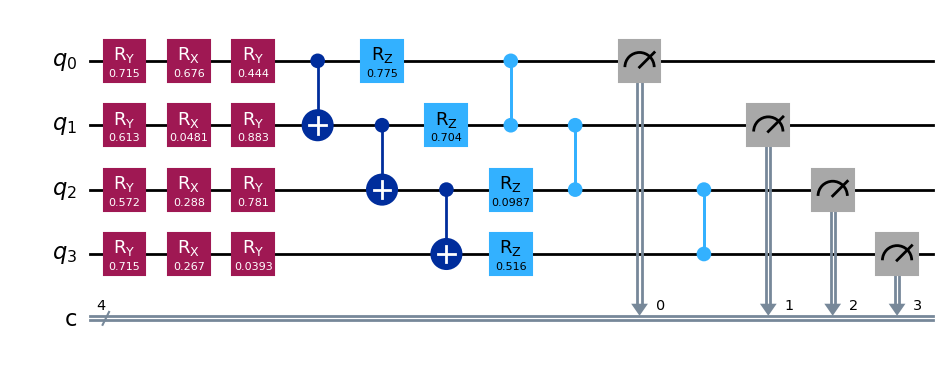

In [11]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import circuit_drawer
import numpy as np

def create_qiskit_circuit(n_qubits, inputs, weights):
    """
    Create a Qiskit circuit equivalent to the PennyLane circuit
    
    Args:
        n_qubits (int): Number of qubits
        inputs (array-like): Input data for amplitude embedding
        weights (array-like): Circuit weights (shape: [3, n_qubits])
    """
    # Create quantum and classical registers
    qr = QuantumRegister(n_qubits, 'q')
    cr = ClassicalRegister(n_qubits, 'c')
    circuit = QuantumCircuit(qr, cr)
    
    # Amplitude Embedding (simplified version)
    # In practice, you'd need a more complex implementation for proper amplitude embedding
    for i in range(n_qubits):
        circuit.ry(inputs[i % len(inputs)], qr[i])
    
    # First variational layer
    for i in range(n_qubits):
        circuit.rx(weights[0][i], qr[i])  # RX gates
    
    for i in range(n_qubits):
        circuit.ry(weights[1][i], qr[i])  # RY gates
    
    # CNOT chain
    for i in range(n_qubits-1):
        circuit.cx(qr[i], qr[i+1])
    
    # Second variational layer
    for i in range(n_qubits):
        circuit.rz(weights[2][i], qr[i])  # RZ gates
    
    # CZ chain
    for i in range(n_qubits-1):
        circuit.cz(qr[i], qr[i+1])
    
    # Measure all qubits
    circuit.measure(qr, cr)
    
    return circuit

# Create example inputs and weights
n_qubits = 4
inputs = np.random.random(3)  # 3 input values
weights = np.random.random((3, n_qubits))  # 3 layers of weights

# Create the circuit
circuit = create_qiskit_circuit(n_qubits, inputs, weights)

# Draw the circuit
print(circuit.draw(output='text'))

# For a more detailed visualization, you can also save it as an image
circuit.draw(output='mpl', filename='qiskit_circuit.png')

In [12]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, n_qubits=0):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(0.3)
        
        if n_qubits > 0:
            print("Tagger will use Quantum LSTM")
            self.lstm = QLSTM(embedding_dim, hidden_dim, n_qubits=n_qubits)
            self.is_quantum = True
        else:
            print("Tagger will use Classical LSTM")
            self.lstm = nn.LSTM(embedding_dim, hidden_dim, dropout=0.3, num_layers=2, bidirectional=True)
            self.is_quantum = False
            
        lstm_output_dim = hidden_dim if self.is_quantum else hidden_dim * 2
        self.hidden2tag = nn.Linear(lstm_output_dim, tagset_size)
        self.layer_norm = nn.LayerNorm(lstm_output_dim)
        
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        embeds = self.dropout(embeds)
        
        if self.is_quantum:
            lstm_out = self.lstm(embeds)
        else:
            lstm_out, _ = self.lstm(embeds.unsqueeze(1))
            lstm_out = lstm_out.squeeze(1)
            
        lstm_out = self.layer_norm(lstm_out)
        lstm_out = self.dropout(lstm_out)
        tag_space = self.hidden2tag(lstm_out)
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [13]:
# Model parameters
embedding_dim = 8
hidden_dim = 6
n_qubits = 4
n_epochs = 50  # Increased epochs
batch_size = 1

In [14]:
# Initialize model
model_classical = LSTMTagger(
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    vocab_size=vocab_size,
    tagset_size=tagset_size,
    n_qubits=0
)

Tagger will use Classical LSTM


## Training

In [15]:
# Training function modifications
def train(model, n_epochs):
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=10,  # First restart after 10 epochs
        T_mult=2,  # Double the restart interval after each restart
        eta_min=1e-6
    )
    
    best_loss = float('inf')
    patience = 15  # Increased patience
    patience_counter = 0
    
    history = {
        'loss': [],
        'acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(n_epochs):
        model.train()
        losses = []
        all_preds = []
        all_targets = []
        
        # Training loop
        for sentence, tags in training_data:
            try:
                model.zero_grad()
                sentence_in = prepare_sequence(sentence, word_to_ix)
                targets = prepare_sequence(tags, tag_to_ix)
                
                # Get model predictions
                tag_scores = model(sentence_in)
                
                # Ensure tag_scores and targets have the same batch size
                if tag_scores.size(0) != targets.size(0):
                    # Trim the longer sequence to match the shorter one
                    min_len = min(tag_scores.size(0), targets.size(0))
                    tag_scores = tag_scores[:min_len]
                    targets = targets[:min_len]
                
                loss = loss_function(tag_scores, targets)
                
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                loss.backward()
                optimizer.step()
                
                losses.append(float(loss))
                all_preds.extend(tag_scores.argmax(dim=-1).tolist())
                all_targets.extend(targets.tolist())
                
            except Exception as e:
                print(f"Error processing sentence: {sentence}")
                print(f"Error message: {str(e)}")
                continue
        
        # Validation phase
        model.eval()
        val_losses = []
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for sentence, tags in testing_data:
                sentence_in = prepare_sequence(sentence, word_to_ix)
                targets = prepare_sequence(tags, tag_to_ix)
                
                tag_scores = model(sentence_in)
                
                # Ensure tag_scores and targets have the same batch size
                if tag_scores.size(0) != targets.size(0):
                    min_len = min(tag_scores.size(0), targets.size(0))
                    tag_scores = tag_scores[:min_len]
                    targets = targets[:min_len]
                
                val_loss = loss_function(tag_scores, targets)
                
                val_losses.append(float(val_loss))
                val_preds.extend(tag_scores.argmax(dim=-1).tolist())
                val_targets.extend(targets.tolist())
        
        # Calculate metrics
        avg_loss = np.mean(losses)
        avg_val_loss = np.mean(val_losses)
        
        accuracy = np.mean([p == t for p, t in zip(all_preds, all_targets)])
        val_accuracy = np.mean([p == t for p, t in zip(val_preds, val_targets)])
        
        scheduler.step(avg_val_loss)
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
        
        history['loss'].append(avg_loss)
        history['acc'].append(accuracy)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{n_epochs}")
        print(f"Train Loss: {avg_loss:.4f} - Train Acc: {accuracy:.4f}")
        print(f"Val Loss: {avg_val_loss:.4f} - Val Acc: {val_accuracy:.4f}")
        print("-" * 50)
    
    model.load_state_dict(torch.load('best_model.pt'))
    return history

In [16]:
history_classical = train(model_classical, n_epochs=25)

Epoch 1/25
Train Loss: 2.1962 - Train Acc: 0.1434
Val Loss: 1.8725 - Val Acc: 0.2871
--------------------------------------------------
Epoch 2/25
Train Loss: 1.9079 - Train Acc: 0.2395
Val Loss: 1.7559 - Val Acc: 0.3861
--------------------------------------------------
Epoch 3/25
Train Loss: 1.7759 - Train Acc: 0.3092
Val Loss: 1.6685 - Val Acc: 0.4208
--------------------------------------------------
Epoch 4/25
Train Loss: 1.7032 - Train Acc: 0.3592
Val Loss: 1.5705 - Val Acc: 0.4604
--------------------------------------------------
Epoch 5/25
Train Loss: 1.6228 - Train Acc: 0.3895
Val Loss: 1.4654 - Val Acc: 0.4703
--------------------------------------------------
Epoch 6/25
Train Loss: 1.5755 - Train Acc: 0.4092
Val Loss: 1.3773 - Val Acc: 0.4703
--------------------------------------------------
Epoch 7/25
Train Loss: 1.4843 - Train Acc: 0.4618
Val Loss: 1.2783 - Val Acc: 0.5693
--------------------------------------------------
Epoch 8/25
Train Loss: 1.4189 - Train Acc: 0.489

C:\Users\HS Tech\AppData\Local\Temp\ipykernel_11656\822005860.py:116: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


In [17]:
def print_result(model):
    with torch.no_grad():
        input_sentence = "We heard the birds chirping loudly in the morning".split() #training_data[8][0]
        labels = ["PRON", "V", "DET", "NN", "V", "ADV", "IN", "DET", "NN"] # training_data[8][1]
        inputs = prepare_sequence(input_sentence, word_to_ix)
        tag_scores = model(inputs)

        tag_ids = torch.argmax(tag_scores, dim=1).numpy()
        tag_labels = [ix_to_tag[k] for k in tag_ids]
        print(f"Sentence:  {input_sentence}")
        print(f"Labels:    {labels}")
        print(f"Predicted: {tag_labels}")

In [18]:
print_result(model_classical)

Sentence:  ['We', 'heard', 'the', 'birds', 'chirping', 'loudly', 'in', 'the', 'morning']
Labels:    ['PRON', 'V', 'DET', 'NN', 'V', 'ADV', 'IN', 'DET', 'NN']
Predicted: ['PRON', 'IN', 'DET', 'NN', 'V', 'ADV', 'IN', 'DET', 'NN']


In [19]:
n_qubits = 4

model_quantum = LSTMTagger(embedding_dim,
                        hidden_dim,
                        vocab_size=len(word_to_ix),
                        tagset_size=len(tag_to_ix),
                        n_qubits=n_qubits)

Tagger will use Quantum LSTM


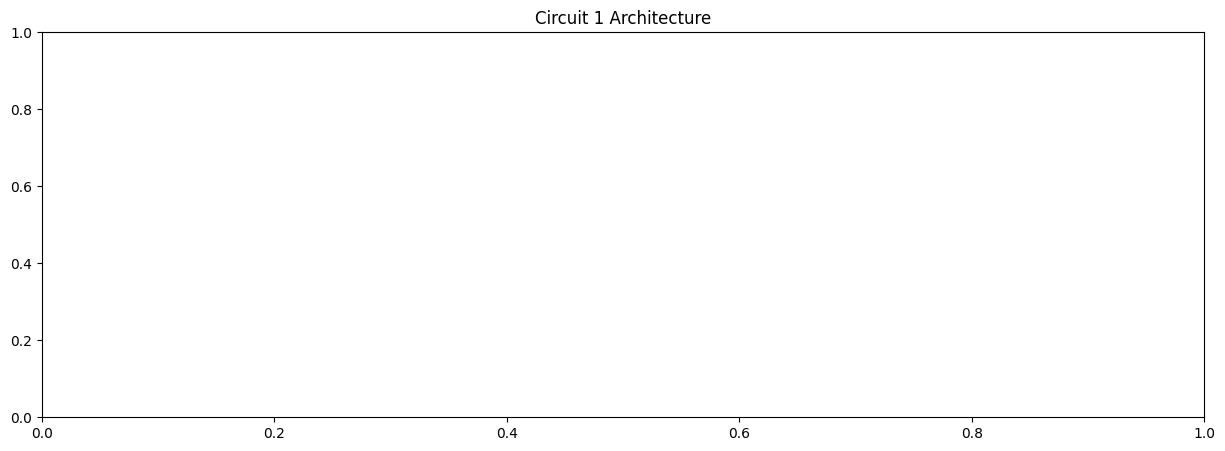

In [20]:
# Circuit 1 Visualization
def visualize_circuit_1():
    n_qubits = 4
    qc = QuantumCircuit(n_qubits)
    
    # Data encoding
    for i in range(n_qubits):
        qc.h(i)
        qc.ry(0.5, i)
    
    # Variational layer
    for i in range(n_qubits):
        qc.rx(0.1, i)
        qc.ry(0.2, i)
        qc.rz(0.3, i)
    
    # Entanglement
    for i in range(n_qubits-1):
        qc.cx(i, i+1)
    
    return qc.draw(output='mpl')

plt.figure(figsize=(15, 5))
visualize_circuit_1()
plt.title("Circuit 1 Architecture")
plt.show()

In [24]:
# First, let's set up the data correctly
import torch
from torch.utils.data import DataLoader, TensorDataset

# Example dataset with matching dimensions
seq_length = 10  # Length of each sequence
input_size = 3   # Number of features per time step
hidden_size = 2  # Size of hidden state
batch_size = 32  # Batch size

# Create sample data
X_train = torch.rand(100, seq_length, input_size)  # 100 samples, sequence length 10, 3 features each
y_train = torch.rand(100, seq_length, hidden_size)  # Target should match model output dimensions

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Updated training function
def train_circuit_1(epochs=50):
    model = QLSTM(input_size=input_size, hidden_size=hidden_size, n_qubits=4)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    losses = []
    accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            
            # Process each sequence in the batch
            batch_output = []
            for i in range(inputs.size(0)):  # For each item in the batch
                output = model(inputs[i])  # Process sequence
                batch_output.append(output)
            
            # Stack outputs
            outputs = torch.stack(batch_output)
            
            # Compute loss
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Computing accuracy (if needed)
            # Note: This is a simplified accuracy metric for regression
            with torch.no_grad():
                accuracy = 1.0 - torch.mean(torch.abs(outputs - targets))
                correct += accuracy.item() * targets.size(0)
                total += targets.size(0)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = (correct / total) * 100
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%')
    
    return losses, accuracies

# Train the model
losses_1, accuracies_1 = train_circuit_1()

Epoch 0: Loss = 0.2521, Accuracy = 57.05%
Epoch 10: Loss = 0.0905, Accuracy = 74.19%
Epoch 20: Loss = 0.0885, Accuracy = 74.63%
Epoch 30: Loss = 0.0907, Accuracy = 74.61%
Epoch 40: Loss = 0.0865, Accuracy = 74.52%


In [ ]:
# Circuit 1 Performance Graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses_1)
plt.title('Circuit 1 Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies_1)
plt.title('Circuit 1 Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

In [ ]:
# Circuit 2 Visualization
def visualize_circuit_2():
    n_qubits = 4
    qc = QuantumCircuit(n_qubits)
    
    # Alternative architecture with different gate sequence
    for i in range(n_qubits):
        qc.h(i)
    
    # Double entanglement layer
    for _ in range(2):
        for i in range(n_qubits-1):
            qc.cx(i, i+1)
        for i in range(n_qubits):
            qc.rz(0.1, i)
    
    return qc.draw(output='mpl')

plt.figure(figsize=(15, 5))
visualize_circuit_2()
plt.title("Circuit 2 Architecture")
plt.show()

In [ ]:
# Circuit 2 Training
def train_circuit_2(epochs=25):
    model = QLSTM(input_size=input_size, hidden_size=hidden_size, n_qubits=4)
    model.quantum_circuit = qml.qnn.TorchLayer(model.create_custom_circuit_v2(), 
                                             {"weights": (model.n_qlayers, model.n_qubits, 3)})
    
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    losses = []
    accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            
            # Process each sequence in the batch
            batch_output = []
            for i in range(inputs.size(0)):
                output = model(inputs[i])
                batch_output.append(output)
            
            # Stack outputs
            outputs = torch.stack(batch_output)
            
            # Compute loss
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Computing accuracy
            with torch.no_grad():
                accuracy = 1.0 - torch.mean(torch.abs(outputs - targets))
                correct += accuracy.item() * targets.size(0)
                total += targets.size(0)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = (correct / total) * 100
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%')
    
    return losses, accuracies


In [ ]:
# Circuit 2 Performance Graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses_2)
plt.title('Circuit 2 Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies_2)
plt.title('Circuit 2 Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

In [ ]:
# Circuit 3 Visualization
def visualize_circuit_3():
    n_qubits = 4
    qc = QuantumCircuit(n_qubits)
    
    # Alternative architecture with different gate sequence
    for i in range(n_qubits):
        qc.h(i)
    
    # Ring topology entanglement
    for i in range(n_qubits):
        qc.cx(i, (i+1)%n_qubits)
    
    # Final rotation layer
    for i in range(n_qubits):
        qc.ry(0.1, i)
    
    return qc.draw(output='mpl')

plt.figure(figsize=(15, 5))
visualize_circuit_3()
plt.title("Circuit 3 Architecture")
plt.show()

In [ ]:
# Circuit 3 Training
def train_circuit_3(epochs=25):
    model = QLSTM(input_size=input_size, hidden_size=hidden_size, n_qubits=4)
    model.quantum_circuit = qml.qnn.TorchLayer(model.create_custom_circuit_v3(), 
                                             {"weights": (model.n_qlayers, model.n_qubits, 3)})
    
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    losses = []
    accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            
            # Process each sequence in the batch
            batch_output = []
            for i in range(inputs.size(0)):
                output = model(inputs[i])
                batch_output.append(output)
            
            # Stack outputs
            outputs = torch.stack(batch_output)
            
            # Compute loss
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Computing accuracy
            with torch.no_grad():
                accuracy = 1.0 - torch.mean(torch.abs(outputs - targets))
                correct += accuracy.item() * targets.size(0)
                total += targets.size(0)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = (correct / total) * 100
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%')
    
    return losses, accuracies

In [ ]:
# Circuit 3 Performance Graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses_3)
plt.title('Circuit 3 Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies_3)
plt.title('Circuit 3 Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

In [ ]:
# Comparison of all three circuits
plt.figure(figsize=(15, 5))

# Loss Comparison
plt.subplot(1, 2, 1)
plt.plot(losses_1, label='Circuit 1')
plt.plot(losses_2, label='Circuit 2')
plt.plot(losses_3, label='Circuit 3')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Comparison
plt.subplot(1, 2, 2)
plt.plot(accuracies_1, label='Circuit 1')
plt.plot(accuracies_2, label='Circuit 2')
plt.plot(accuracies_3, label='Circuit 3')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()